# GRIP_JULY - 2021  (TASK 3)

# Task Name:- Social Distancing Detector

# Domain:- Computer Vision and IOT

# Name:- Akash Singh

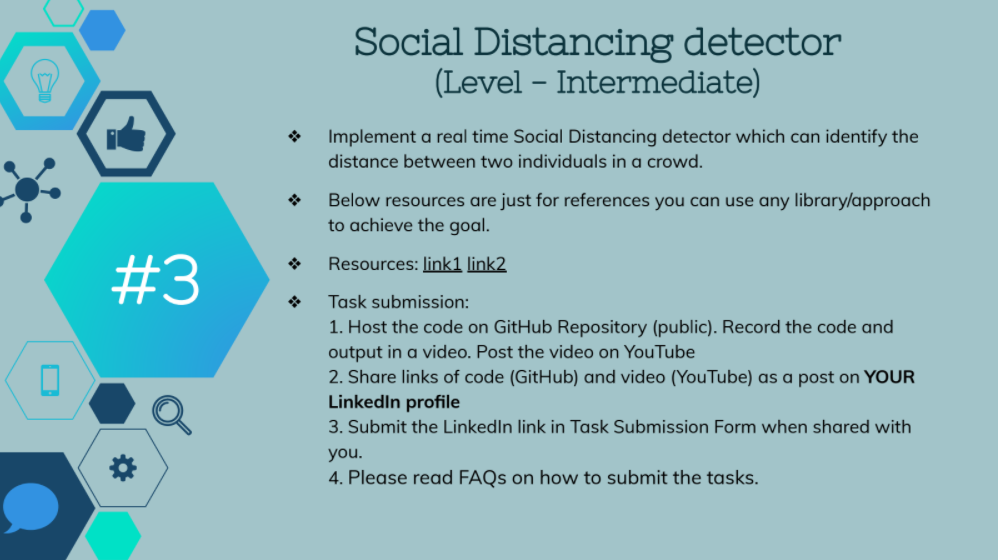

### Importing the required libraries

In [ ]:
from simplecode import social_distancing_config as config
from simplecode.detection import detect_people
from scipy.spatial import distance as dist
import numpy as np
import argparse
import imutils
import cv2
import os

### construct the argument parse and parse the arguments

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", type=str, default="", help="path to (optional) input video file")
ap.add_argument("-o", "--output", type=str, default="", help="path to (optional) output video file")
ap.add_argument("-d", "--display", type=int, default=1, help="whether or not output frame should be displayed")
args = vars(ap.parse_args())

### load the COCO class labels our YOLO model was trained on

In [ ]:
labelsPath = "coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

### derive the paths to the YOLO weights and model configuration

In [ ]:
weightsPath = "yolov3.weights"
configPath = "yolov3.cfg"

### load our YOLO object detector trained on COCO dataset (80 classes)

In [ ]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

### check if we are going to use GPU

In [ ]:
if config.USE_GPU:
	# set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

### determine only the *output* layer names that we need from YOLO

In [ ]:
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

### initialize the video stream and pointer to output video file

In [ ]:
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 'VIDEO1.mp4')
writer = None

### loop over the frames from the video stream

In [ ]:
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# resize the frame and then detect people (and only people) in it
	frame = imutils.resize(frame, width=700)
	results = detect_people(frame, net, ln,
		personIdx=LABELS.index("person"))

	# initialize the set of indexes that violate the minimum social
	# distance
	violate = set()

	# ensure there are *at least* two people detections (required in
	# order to compute our pairwise distance maps)
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = np.array([r[2] for r in results])
		D = dist.cdist(centroids, centroids, metric="euclidean")

		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < config.MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violate.add(i)
					violate.add(j)

	# loop over the results
	for (i, (prob, bbox, centroid)) in enumerate(results):
		# extract the bounding box and centroid coordinates, then
		# initialize the color of the annotation
		(startX, startY, endX, endY) = bbox
		(cX, cY) = centroid
		color = (0, 255, 0)

		# if the index pair exists within the violation set, then
		# update the color
		if i in violate:
			color = (0, 0, 255)

		# draw (1) a bounding box around the person and (2) the
		# centroid coordinates of the person,
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		cv2.circle(frame, (cX, cY), 5, color, 1)

	# draw the total number of social distancing violations on the
	# output frame
	text = "Social Distancing Violations: {}".format(len(violate))
	cv2.putText(frame, text, (10, frame.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

	# check to see if the output frame should be displayed to our
	# screen
	if args["display"] > 0:
		# show the output frame
		cv2.imshow("Frame", frame)
		key = cv2.waitKey(1) & 0xFF

		# if the `q` key was pressed, break from the loop
		if key == ord("q"):
			break

	# if an output video file path has been supplied and the video
	# writer has not been initialized, do so now
	if args["output"] != "" and writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

	# if the video writer is not None, write the frame to the output
	# video file
	if writer is not None:
		writer.write(frame)